### Trying out Hyperparameter Tuning with the newer Pytorch Lightning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger

from ray import air, tune
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler, PopulationBasedTraining
from ray.tune.integration.pytorch_lightning import TuneReportCallback, TuneReportCheckpointCallback
from sklearn.metrics import r2_score, mean_squared_error

import pandas as pd
import numpy as np
from plotnine import *
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
import os

from IPython.display import clear_output

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
pd.set_option('display.max.columns', 500)

In [2]:
# Read data
data = (pd.read_csv("data_prepped.csv", parse_dates=['date'])
        .assign(year=lambda x: x.date.dt.year))

# Splitting data by time
dt_train = data.query("year <= 2017")
dt_test = data.query("year == 2018")
holdout = data.query("year == 2019")

In [3]:
# Prepare data
X_train = dt_train.drop(["mwh", "date"], axis=1).reset_index(drop=True)
y_train = dt_train["mwh"].reset_index(drop=True)

X_test = dt_test.drop(["mwh", "date"], axis=1).reset_index(drop=True)
y_test = dt_test["mwh"].reset_index(drop=True)

X_holdout = holdout.drop(["mwh", "date"], axis=1).reset_index(drop=True)
y_holdout = holdout["mwh"].reset_index(drop=True)

In [4]:
class CustomDataset(Dataset):
    '''
    Prepare the custom dataset for regression
    '''
    def __init__(self, X, y):
      self.X = torch.from_numpy(np.float32(np.asarray(X)))
      self.y = torch.from_numpy(np.float32(np.asarray(y)))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [5]:
train_dataset = CustomDataset(X=X_train, y=y_train)
test_dataset = CustomDataset(X=X_test, y=y_test)
holdout_dataset = CustomDataset(X=X_holdout, y=y_holdout)

In [40]:
class ANN(pl.LightningModule):
    '''
    Artificial Neural Network
    '''
    def __init__(self, input_dim, config):
        super().__init__()
        # for loading from checkpoint later
        self.save_hyperparameters()

        self.lr = config["lr"]
        self.batch_size = config["batch_size"]
        
        self.nodes1 = config["nodes1"]
        self.nodes2 = config["nodes2"]
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, config["nodes1"]),
            nn.ReLU(),
            nn.Linear(config["nodes1"], config["nodes2"]),
            nn.ReLU(),
            nn.Linear(config["nodes2"], 1)
        )

        self.loss_fn = nn.L1Loss()

    def forward(self, x):
        '''
        Forward pass
        '''
        return self.layers(x)
    
    def predict_step(self, batch, batch_idx):
        x, y_ = batch
        return self(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = self.loss_fn(y_pred, y)
        # r_squared = torch.from_numpy(np.array(r2_score(y_pred.cpu().detach().numpy(), y.cpu().detach().numpy())))
        self.log('train_loss', loss)
        # self.log('train_r2', r_squared)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = self.loss_fn(y_pred, y)
        # r_squared = torch.from_numpy(np.array(r2_score(y_pred.cpu().detach().numpy(), y.cpu().detach().numpy())))
        # self.log('val_loss', loss, on_epoch=True, on_step=False)
        # self.log('val_loss', loss, on_epoch=True, on_step=False)
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
        # take the mean of the two metrics at the end of each epoch
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        # avg_r_squared = torch.stack([x["val_r_squared"] for x in outputs]).mean()
        self.log("val_loss", avg_loss)
        # self.log("val_r_squared", avg_r_squared)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = self.loss_fn(y_pred, y)
        # r_squared = torch.from_numpy(np.array(r2_score(y_pred.cpu().detach().numpy(), y.cpu().detach().numpy())))
        self.log('test_loss', loss, on_epoch=True, on_step=False)
        # self.log('test_r_squared', r_squared, on_epoch=True, on_step=False)

    # not quite right to call external variables, but gonna fix it later
    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=int(self.batch_size), shuffle=True)

    def val_dataloader(self):
        return DataLoader(test_dataset, batch_size=int(self.batch_size), shuffle=True)
    
    def test_dataloader(self):
        return DataLoader(holdout_dataset, batch_size=10, shuffle=False)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [41]:
def train_tune(config, num_epochs=50):
    model = ANN(X_train.shape[1], config)
    # Do I even need this line with lightning?
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)

    callbacks = [EarlyStopping(monitor="val_loss", patience=15),
                 TuneReportCallback({"loss": "val_loss"},
                                    on="validation_end"),
                 ModelCheckpoint(dirpath="./checkpoints/",
                                 filename='model',
                                 save_top_k=1,
                                 verbose=False,
                                 monitor='val_loss',
                                 mode='min'
                                 )]

    trainer = pl.Trainer(
        max_epochs=num_epochs,
        logger=TensorBoardLogger(save_dir=os.getcwd(),
                                 version="0"),
        enable_progress_bar=False,
        callbacks=callbacks)
    trainer.fit(model)


In [42]:
# Defining a search space!
config = {
    "nodes1": tune.choice([2**x for x in range(4, 10 + 1)]),
    "nodes2": tune.choice([2**x for x in range(4, 10 + 1)]),
    "lr": tune.loguniform(1e-4, 0.5e-1),
    "batch_size": tune.choice([2**x for x in range(2, 9 + 1)])
}

# Execute the hyperparameter search
analysis = tune.run(tune.with_parameters(train_tune, num_epochs=200),
                    num_samples=100, # How many hyperparam combinations to try
                    config=config, # Grid of hyperparams to iterate over
                    local_dir='logs_ray', # where to log results
                    scheduler=ASHAScheduler(time_attr='training_iteration', 
                                            grace_period=30,
                                            reduction_factor=1.5),
                    metric="loss",
                    mode="min",
                    progress_reporter=JupyterNotebookReporter(overwrite=True,
                                                              max_progress_rows=10),
                    name='ANN',
                    verbose=1,
                    fail_fast=False)


2023-03-31 10:07:05,529	WARNING worker.py:1866 -- Warning: The actor ImplicitFunc is very large (17 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(train_tune pid=20316) GPU available: False, used: False
(train_tune pid=20316) TPU available: False, using: 0 TPU cores
(train_tune pid=20316) IPU available: False, using: 0 IPUs
(train_tune pid=20316) HPU available: False, using: 0 HPUs
(train_tune pid=20316) 
(train_tune pid=20316)   | Name    | Type       | Params
(train_tune pid=20316) ---------------------------------------
(train_tune pid=20316) 0 | layers  | Sequential | 72.6 K
(train_tune pid=20316) 1 | loss_fn | L1Loss     | 0     
(train_tune pid=20316) ---------------------------------------
(train_tune pid=20316) 72.6 K    Trainable params
(train_tune pid=20316) 0         Non-trainable params
(train_tune pid=20316) 72.6 K    Total params
(train_tune pid=20316) 0.

In [53]:
analysis.best_config

{'nodes1': 256, 'nodes2': 32, 'lr': 0.010238805244585286, 'batch_size': 8}

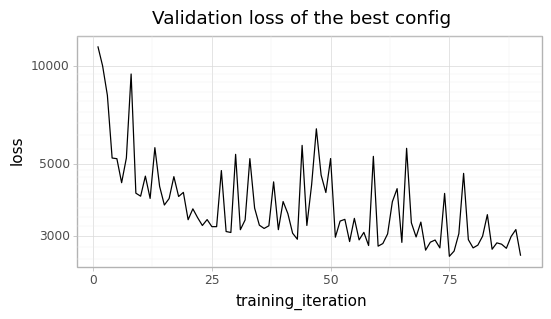

<ggplot: (104239621658)>

In [54]:
(
    ggplot(data=(analysis.best_dataframe),
           mapping=aes(x='training_iteration', y='loss')) +
    geom_line() +
    labs(title='Validation loss of the best config') +
    scale_y_log10() +
    theme_light() +
    theme(figure_size=[6,3])
)

In [55]:
dfs = analysis.trial_dataframes

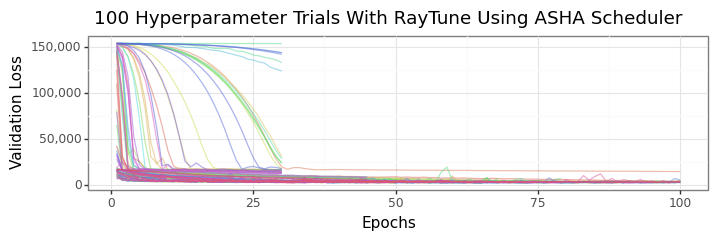

<ggplot: (104244113577)>

In [159]:
p = (
    ggplot(data=pd.concat(dfs.values()),
           mapping=aes(x='iterations_since_restore', y='loss', colour='trial_id')) +
    geom_line(alpha=0.5) +
    guides(colour=None) +
    labs(title='100 Hyperparameter Trials With RayTune Using ASHA Scheduler',
         y='Validation Loss', x='Epochs') +
    scale_y_continuous(labels=comma_format()) +
    theme_bw() +
    theme(figure_size=[8,2])

)

p

In [160]:
p.save(dpi=350, filename='python.png')

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 8 x 2 in image.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: python.png


### Load the best model from checkpoint:

In [46]:
best_model_dir_stem = analysis.get_best_trial(metric='loss', mode='min').logdir
best_model_dir = best_model_dir_stem + "\\checkpoints\\model.ckpt"
best_model_dir

'c:\\Users\\mathi\\OneDrive\\Python\\52-Weeks-of-Python-and-R-2023\\12 - PyTorch Hyperparameter Tuning\\logs_ray\\ANN\\train_tune_0237e_00028_28_batch_size=8,lr=0.0102,nodes1=256,nodes2=32_2023-03-31_10-11-25\\checkpoints\\model.ckpt'

In [47]:
final_model = ANN.load_from_checkpoint(best_model_dir)

In [48]:
final_model.eval()
holdout_values = torch.from_numpy(np.float32(np.asarray(X_holdout)))
with torch.no_grad():
    holdout_preds = final_model(holdout_values)

In [49]:
rmse_holdout = mean_squared_error(y_pred=holdout_preds.numpy().ravel(),
                                  y_true=holdout.mwh.reset_index(drop=True),
                                  squared=False)

r2_holdout = r2_score(y_pred=holdout_preds.numpy().ravel(),
                      y_true=holdout.mwh.reset_index(drop=True))

print(f"RMSE on holdout: {rmse_holdout:.2f}")
print(f"R2 on holdout: {r2_holdout:.4f}")


RMSE on holdout: 4279.37
R2 on holdout: 0.9623


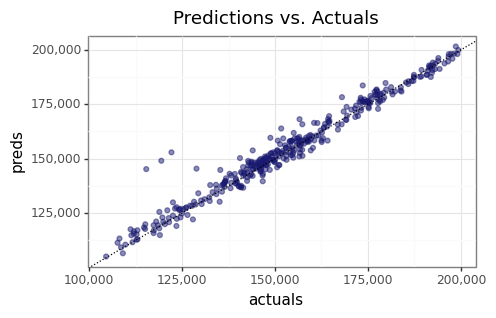

<ggplot: (104246089993)>

In [92]:
p = (
    ggplot(data=(pd.DataFrame({'preds': holdout_preds.numpy().ravel(),
                               'actuals': holdout.mwh})
                 ),
           mapping=aes(x='actuals', y='preds')) +
    geom_point(alpha=0.5, colour='midnightblue') +
    geom_abline(linetype='dotted') +
    labs(title='Predictions vs. Actuals') +
    scale_y_continuous(labels=comma_format()) +
    scale_x_continuous(labels=comma_format()) +
    theme_bw() +
    theme(figure_size=[5, 3])
)

p

In [93]:
p.save(dpi=350, filename='python1.png')

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 3 in image.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: python1.png


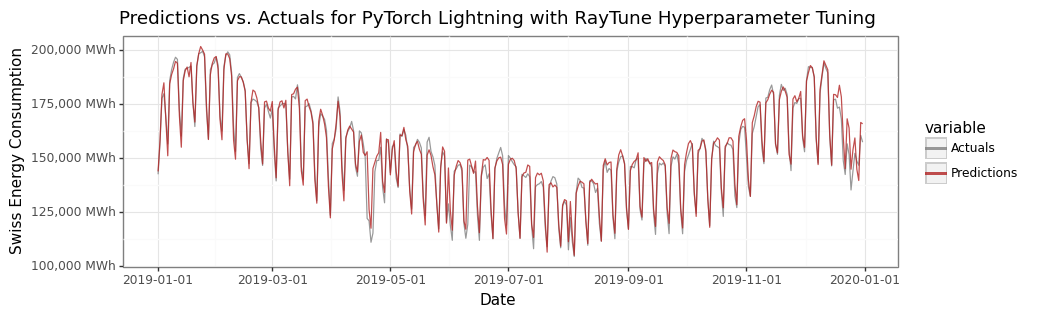

<ggplot: (104246480197)>

In [94]:
p = (
    ggplot(data=(pd.DataFrame({'Predictions': holdout_preds.numpy().ravel(),
                               'Actuals': holdout['mwh'],
                               'Date': holdout['date']})
                 .melt(id_vars='Date')
                 ),
           mapping=aes(x='Date', y='value', colour='variable')) +
    geom_line(alpha=0.8) +
    labs(title='Predictions vs. Actuals for PyTorch Lightning with RayTune Hyperparameter Tuning',
         y='Swiss Energy Consumption') +
    scale_y_continuous(labels=currency_format(prefix='',
                                              suffix=' MWh',
                                              big_mark=',',
                                              digits=0)) +
    scale_colour_manual(values=['grey', 'firebrick']) +
    theme_bw() +
    theme(figure_size=[10, 3])
)

p


### Comparing the results to the untuned model

In [108]:
preds_untuned = pd.read_csv("predictions_untuned.csv",
                            parse_dates=['Date'])

In [109]:
preds_tuned = pd.DataFrame({'Predictions_Tuned': holdout_preds.numpy().ravel(),
                            'Actuals': holdout['mwh'],
                            'Date': holdout['date']})

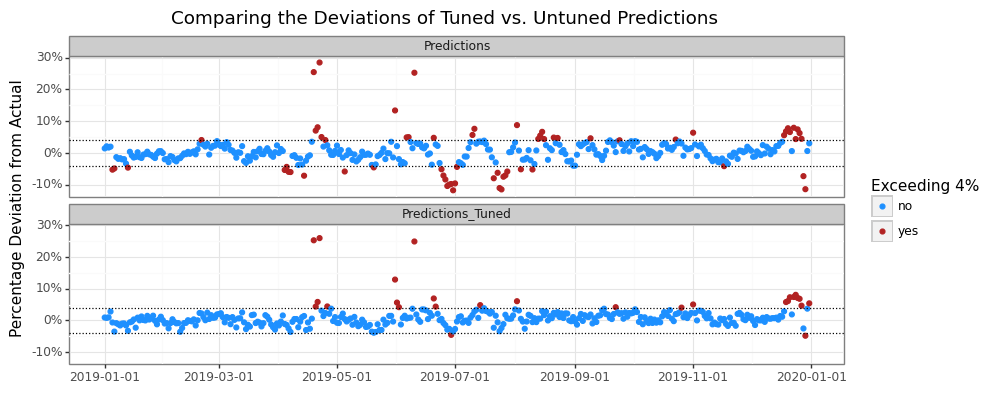

<ggplot: (104247901221)>

In [156]:
p = (
    ggplot(data=(preds_tuned
                 .merge(preds_untuned)
                 .melt(id_vars=['Actuals', 'Date'])
                 .assign(delta=lambda x: x['value']/x['Actuals'] - 1,
                         colour_index=lambda x: np.where(np.abs(x['delta']) > 0.04, 'yes', 'no'))
                 ),
           mapping=aes(x='Date', y='delta', colour='colour_index')) +
    geom_point() +
    geom_hline(yintercept=0.04, linetype='dotted') +
    geom_hline(yintercept=-0.04, linetype='dotted') +
    facet_wrap('~ variable', nrow=2) +
    labs(title='Comparing the Deviations of Tuned vs. Untuned Predictions',
         y='Percentage Deviation from Actual', x=None, colour="Exceeding 4%") +
    scale_colour_manual(values=['dodgerblue', 'firebrick']) +
    scale_y_continuous(labels=percent_format()) +
    theme_bw() +
    theme(figure_size=[10, 4])
)

p

In [157]:
p.save(dpi=350, filename='python4.png')

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 10 x 4 in image.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: python4.png


We can also look at the tuning results using a Tensorboard:

In [146]:
# Start tensorboard.
%reload_ext tensorboard